In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

2026-01-15 14:00:17.138448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768485617.320452      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768485617.372857      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768485617.802523      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768485617.802563      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768485617.802566      55 computation_placer.cc:177] computation placer alr

In [3]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
# Create 80/10/10 Split

# Combine train + test
X = np.concatenate((x_train_full, x_test_full), axis=0)
y = np.concatenate((y_train_full, y_test_full), axis=0)

# Shuffle dataset
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

# Split sizes
total = len(X)
train_size = int(0.8 * total)
val_size   = int(0.1 * total)

# Split
x_train = X[:train_size]
y_train = y[:train_size]

x_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

x_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Train:", x_train.shape)
print("Validation:", x_val.shape)
print("Test:", x_test.shape)

Train: (48000, 32, 32, 3)
Validation: (6000, 32, 32, 3)
Test: (6000, 32, 32, 3)


In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = 224

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # 🔑 KEY FIX
    return image, label

In [6]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = (
    train_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)                 # 🔑 REQUIRED
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)                 # 🔑 REQUIRED
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)                 # 🔑 REQUIRED
    .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1768485643.856283      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
for images, labels in train_ds.take(1):
    print(images.shape)

(32, 224, 224, 3)


In [9]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


I0000 00:00:1768485732.497504     129 service.cc:152] XLA service 0x7d4f90150240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768485732.497550     129 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768485734.255430     129 cuda_dnn.cc:529] Loaded cuDNN version 91002


   2/1500 ━━━━━━━━━━━━━━━━━━━━ 1:19 53ms/step - accuracy: 0.1250 - loss: 2.6294  

I0000 00:00:1768485737.896308     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 103s 60ms/step - accuracy: 0.8307 - loss: 0.4898 - val_accuracy: 0.8662 - val_loss: 0.3964
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.9058 - loss: 0.2712 - val_accuracy: 0.9073 - val_loss: 0.2687
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.9202 - loss: 0.2204 - val_accuracy: 0.9100 - val_loss: 0.2688
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.9355 - loss: 0.1818 - val_accuracy: 0.9045 - val_loss: 0.2980
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 85s 56ms/step - accuracy: 0.9447 - loss: 0.1537 - val_accuracy: 0.8998 - val_loss: 0.3211
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 85s 56ms/step - accuracy: 0.9530 - loss: 0.1294 - val_accuracy: 0.9092 - val_loss: 0.2953
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 85s 56ms/step - accuracy: 0.9649 - loss: 0.0991 - val_accuracy: 0.9105 - val_loss: 0.3392
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.9696 - loss: 0.0

In [12]:
baseline_val_acc = max(history_1.history['val_accuracy'])
print(f"Baseline Validation Accuracy: {baseline_val_acc * 100:.2f}%")

Baseline Validation Accuracy: 91.05%


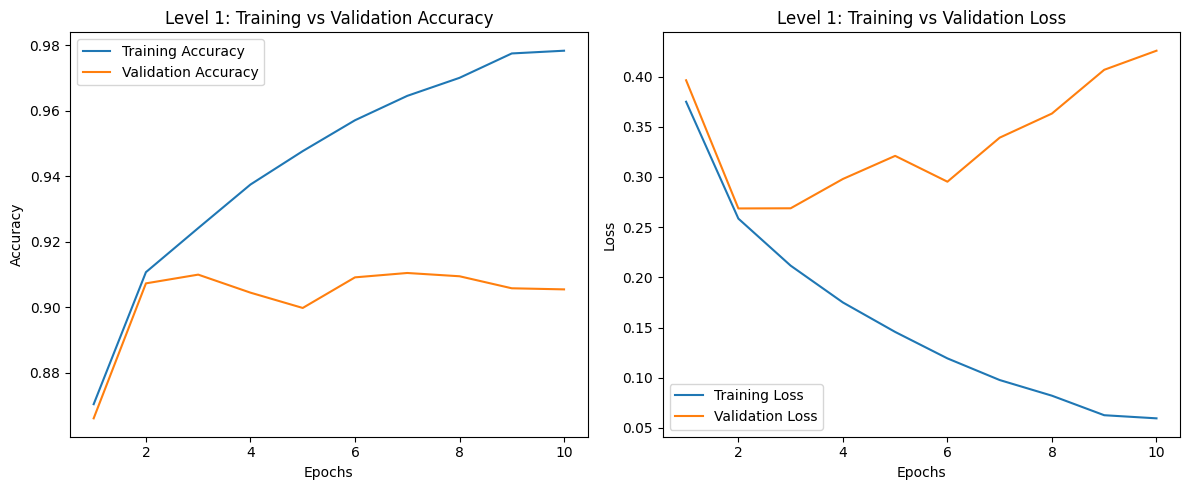

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_1.history["accuracy"]) + 1)

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs, history_1.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, history_1.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Level 1: Training vs Validation Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, history_1.history["loss"], label="Training Loss")
plt.plot(epochs, history_1.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Level 1: Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

****LEVEL 2****

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [15]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    data_augmentation,          # ✅ Level 2
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 154s 96ms/step - accuracy: 0.6932 - loss: 1.0583 - val_accuracy: 0.8877 - val_loss: 0.3344
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 142s 94ms/step - accuracy: 0.7903 - loss: 0.6200 - val_accuracy: 0.8975 - val_loss: 0.3160
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 139s 92ms/step - accuracy: 0.7953 - loss: 0.5910 - val_accuracy: 0.8903 - val_loss: 0.3267
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 93ms/step - accuracy: 0.8002 - loss: 0.5705 - val_accuracy: 0.9013 - val_loss: 0.2994
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 93ms/step - accuracy: 0.8160 - loss: 0.5410 - val_accuracy: 0.9018 - val_loss: 0.3066
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 93ms/step - accuracy: 0.8175 - loss: 0.5330 - val_accuracy: 0.9047 - val_loss: 0.2863
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 93ms/step - accuracy: 0.8227 - loss: 0.5224 - val_accuracy: 0.9055 - val_loss: 0.2827
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 93ms/step - accuracy: 

In [26]:
Level_2_val_acc = max(history_2.history['val_accuracy'])
print(f"Level 2 Validation Accuracy: {baseline_val_acc * 100:.2f}%")

Level 2 Validation Accuracy: 90.92%


In [27]:
print("===== Accuracy Comparison (Ablation Study) =====")
print(f"Without Data Augmentation:")
print(f"  Validation Accuracy : {max(history_1.history['val_accuracy']) * 100:.2f}%")

print("\nWith Data Augmentation:")
print(f"  Validation Accuracy : {max(history_2.history['val_accuracy']) * 100:.2f}%")



===== Accuracy Comparison (Ablation Study) =====
Without Data Augmentation:
  Validation Accuracy : 91.05%

With Data Augmentation:
  Validation Accuracy : 90.92%
